# Настройка рабочего окружения

In [1]:
%autosave 60
%reload_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, "..")

Autosaving every 60 seconds


In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"unk","key":"unk"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c teta-nn-1-2025
# !unzip /kaggle/working/teta-nn-1-2025
!unzip teta-nn-1-2025

  0%|                                               | 0.00/20.3M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 20.3M/20.3M [00:00<00:00, 958MB/s]
Archive:  teta-nn-1-2025.zip
  inflating: sample_submition.csv    
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
# kaggle
%env CLEARML_API_ACCESS_KEY=
%env CLEARML_API_SECRET_KEY=

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=39DYHI993M8WJRSRHIITK8YZ3EKNBE
env: CLEARML_API_SECRET_KEY=fqbnjs0VYFxh_ulCIVWbdGwwGJwK6Zz9BYn9uyEzD9Bd3-SIMSgjRBCGccXnZ57xgdo


In [ ]:
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoTokenizer, BertModel, BertTokenizerFast

try:
    from clearml import InputModel, Task, TaskTypes
except ModuleNotFoundError:
    print("Артефакты будут сохраняться локально")

2025-07-24 19:31:16.652600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753385476.676608     556 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753385476.683806     556 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
RANDOM_SEED = 64

np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)  # Для всех GPU

device= "cuda" if torch.cuda.is_available() else "cpu"

# Основная работа

In [5]:
# df_train = pd.read_csv("./train.csv")
# .sample(60, random_state=RANDOM_SEED)
df_train = pd.read_csv("/kaggle/working/train.csv")
# df_train = df_train.drop(columns=["company", "salary_from"])

df_train.head()

,title,location,company,skills,description,experience_from,salary_from,log_salary_from
0,Специалист технической поддержки,Воронеж,ВКТМ,NaN,"Обязанности: Обеспечение бесперебойной работы всех ПК и устранение неисправностей; Установка и настройка ПО для корректной работы; Ремонт используемой техники; Обеспечение информационной безопасности и защиты от хакерских атак и спама; Сопровождение настройки системы видеонаблюдения, СКУД, «Битрикс», 1С; Техническое обслуживание работы компьютеров и оргтехники, заправка картриджей, ремонт компьютеров и оргтехники; Ведение базы заявок на обслуживание, ремонт, заказ комплектующих для компьютеров и оргтехники; Сборка, диагностика и подключение рабочих компьютеров, серверов; ...",1.0,60.0,4.094345
1,Product Owner в ИТ-стартап (B2C),Москва,Radium Finance,"CustDev, Стратегический менеджмент, Управление стейкхолдерами, Управление ожиданиями, Управление командой, Постановка задач разработчикам, Product-market fit, Customer Journey Mapping, User Story Mapping, Управление бэклогом, Управление ресурсами","Эта вакансия про тебя, если симбиоз управленческой зрелости, стратегического видения, аналитических навыков, продуктового кругозора и глубокого погружение в бизнес — есть в твоем бэкграунде. Большой плюс — опыт запуска нового продукта на рынок. Продукт Мы ИТ-стартап на грани прорыва, делаем социальную сеть для людей-инвесторов и всех, кто хочет повышать свою финансовую грамотность. Это будет реально огромное сообщество, объединенных общими интересами. Не олько интересное, познавательное, местами развлекательное, но и приносящие пользу. Причем как новичкам, так и тем, кто на инвестици...",6.0,200.0,5.298317
2,Системный администратор ( Клинический Госпиталь на Яузе ),Москва,Медскан,NaN,"АО «Медскан» – динамично развивающаяся группа компаний и один из лидеров негосударственного сектора здравоохранения в России. Медицинские учреждения холдинга предлагают полный спектр высокотехнологичной медицинской помощи по передовым мировым протоколам. В 31 регионе и 105 городах России работает 65 медицинских центров, 15 лабораторий и более 430 лабораторных медицинских офисов ГК «Медскан». Флагманом группы является российский филиал университетского госпиталя Hadassah (Иерусалим). «Клинический госпиталь на Яузе» входит в ГК «Медскан» и занимает 10 место в «ТОП-200 клиник России» п...",1.0,130.0,4.867534
3,Системный Администратор Linux,Москва,Selecty,"Linux, PostgreSQL","Задачи: Администрирование инфраструктуры на базе Linux; Оптимизация производительности и обеспечение отказоустойчивости систем; Решение проблем доступности, целостности данных; Ведение технической документации. Требования: Опыт по администрированию Linux/Unix; Понимание состава баз данных, индексы, статистика, планы обслуживания; Опыт работы СУБД PostgreSQL; Опыт эксплуатации систем мониторинга и резервного копирования; Знание принципов работы основных сетевых служб и протоколов. Условия: Удаленный формат работы, график 5/2; Трудоустройство в ИТ-аккреди...",3.0,170.0,5.135798
4,Начальник участка общестроительных работ,Пушкино (Московская область),NK GROUP,NaN,"NK Group – ведущий девелопер индустриальных объектов в России. NK Group реализует промышленные объекты полного цикла: строительство в собственных парках, оснащенных всеми коммуникациями, а также на земле клиента. NK Group ищет сотрудника на должность Начальник участка . Вы понимаете конечный результат своей деятельности и добиваетесь его? В Вашем опыте работы есть законченные проекты? Вы можете назвать себя настойчивым человеком, которого не собьют с цели никакие преграды? Вы ""дружите"" с цифрами и работа с графиками и бюджетом для Вас не проблема? Что мы от Вас ожидаем: У в...",3.0,200.0,5.298317


In [ ]:
# class GroupStatisticsCalculator:
#     def __init__(self):
#         self.group_stats = {}

#     def fit(self, df: pd.DataFrame, group_by: list[str], target: str):
#         """
#         Вычисляет статистики для групп, заданных в `group_by`, по целевой колонке `target`.
#         """
#         grouped = df.groupby(group_by)[target]
#         self.group_stats = grouped.agg(['mean', 'median', 'min', 'max', 'std'])

#         self.group_stats = self.group_stats.rename(columns={
#             k: f"{target}_{k}" for k in self.group_stats.columns
#         }).to_dict('index')

#     def transform(self, df: pd.DataFrame, group_by: list[str]) -> pd.DataFrame:
#         """
#         Применяет сохранённые статистики к новому DataFrame.
#         """
#         if not self.group_stats:
#             raise ValueError("Сначала вызовите метод fit, чтобы вычислить статистики.")
        
#         stats_df = pd.DataFrame.from_dict(self.group_stats, orient='index')

#         df_columns_stat = [f"{col}_by_" + "_".join(group_by) for col in stats_df.columns]
#         stats_df = stats_df.rename(columns={
#             k: v for k, v in zip(stats_df.columns.tolist(), df_columns_stat)
#         })

#         stats_df = stats_df.reset_index()
#         if "index" in stats_df.columns:
#             stats_df = stats_df.rename(columns={"index": group_by[0]})
#         else:
#             stats_df = stats_df.rename(
#                 columns={f"level_{i}": v for i, v in enumerate(group_by)}
#             )

#         # Объединяем статистики с исходным DataFrame
#         df = df.merge(stats_df, on=group_by, how='left')

#         # Если нужно, можно заполнить пропущенные значения
#         df[df_columns_stat] = df[df_columns_stat].fillna(0)

#         return df

#     def fit_transform(self, df: pd.DataFrame, group_by: list[str], target: str) -> pd.DataFrame:
#         """
#         Вычисляет статистики и сразу применяет их к данным.
#         """
#         self.fit(df, group_by, target)
#         return self.transform(df, group_by)

#     def get_stats(self) -> dict:
#         """
#         Возвращает сохранённые статистики.
#         """
#         return self.group_stats

In [ ]:
# with open("/kaggle/input/teta-nn-1/companies.json") as f:
#     companies = pd.DataFrame.from_dict(json.load(f), orient="index").reset_index().rename(columns={
#     "index": "company",
#     0: "url_companies"
# })

# with open("/kaggle/input/teta-nn-1/industries.json") as f:
#     industries = pd.DataFrame.from_dict(json.load(f), orient="index").reset_index().rename(columns={
#     "index": "url_companies"
# })

# companies_and_ind = companies.merge(
#     industries,
#     how="inner",
#     on="url_companies"
# )

# companies_explode = []

# for row in tqdm(companies_and_ind.iterrows(), total=len(companies_and_ind)):
#     companies_info_industries = []
#     for i in range(5):
#         if row[1][i]:
#             companies_explode.append([row[1]["company"], row[1][i]["id"], row[1][i]["name"]])

# companies_explode = pd.DataFrame(companies_explode)

# companies_explode = companies_explode.rename(columns={
#     0: "company",
#     1: "id",
#     2: "name_ind"
# }).astype({"id": float}).astype({"id": int}).sort_values(by=["company", "id"])

# companies_explode = companies_explode.drop_duplicates(subset=("company", "id"))[["company", "id"]]

# companies_pivot = companies_explode.groupby("company")["id"].apply(lambda x: " ".join(map(str, x)))

# companies_pivot["group_index"] = companies_pivot.groupby("company").cumcount()
# companies_pivot = companies_pivot.pivot(index="company", columns="group_index", values=["id", "name_ind"])

# companies_pivot.columns = [f"{col[0]}_{col[1]+1}" for col in companies_pivot.columns]

100%|██████████| 9416/9416 [00:00<00:00, 15961.09it/s]


In [6]:
df_train

,title,location,company,skills,description,experience_from,salary_from,log_salary_from
0,Специалист технической поддержки,Воронеж,ВКТМ,NaN,"Обязанности: Обеспечение бесперебойной работы всех ПК и устранение неисправностей; Установка и настройка ПО для корректной работы; Ремонт используемой техники; Обеспечение информационной безопасности и защиты от хакерских атак и спама; Сопровождение настройки системы видеонаблюдения, СКУД, «Битрикс», 1С; Техническое обслуживание работы компьютеров и оргтехники, заправка картриджей, ремонт компьютеров и оргтехники; Ведение базы заявок на обслуживание, ремонт, заказ комплектующих для компьютеров и оргтехники; Сборка, диагностика и подключение рабочих компьютеров, серверов; ...",1.0,60.0,4.094345
1,Product Owner в ИТ-стартап (B2C),Москва,Radium Finance,"CustDev, Стратегический менеджмент, Управление стейкхолдерами, Управление ожиданиями, Управление командой, Постановка задач разработчикам, Product-market fit, Customer Journey Mapping, User Story Mapping, Управление бэклогом, Управление ресурсами","Эта вакансия про тебя, если симбиоз управленческой зрелости, стратегического видения, аналитических навыков, продуктового кругозора и глубокого погружение в бизнес — есть в твоем бэкграунде. Большой плюс — опыт запуска нового продукта на рынок. Продукт Мы ИТ-стартап на грани прорыва, делаем социальную сеть для людей-инвесторов и всех, кто хочет повышать свою финансовую грамотность. Это будет реально огромное сообщество, объединенных общими интересами. Не олько интересное, познавательное, местами развлекательное, но и приносящие пользу. Причем как новичкам, так и тем, кто на инвестици...",6.0,200.0,5.298317
2,Системный администратор ( Клинический Госпиталь на Яузе ),Москва,Медскан,NaN,"АО «Медскан» – динамично развивающаяся группа компаний и один из лидеров негосударственного сектора здравоохранения в России. Медицинские учреждения холдинга предлагают полный спектр высокотехнологичной медицинской помощи по передовым мировым протоколам. В 31 регионе и 105 городах России работает 65 медицинских центров, 15 лабораторий и более 430 лабораторных медицинских офисов ГК «Медскан». Флагманом группы является российский филиал университетского госпиталя Hadassah (Иерусалим). «Клинический госпиталь на Яузе» входит в ГК «Медскан» и занимает 10 место в «ТОП-200 клиник России» п...",1.0,130.0,4.867534
3,Системный Администратор Linux,Москва,Selecty,"Linux, PostgreSQL","Задачи: Администрирование инфраструктуры на базе Linux; Оптимизация производительности и обеспечение отказоустойчивости систем; Решение проблем доступности, целостности данных; Ведение технической документации. Требования: Опыт по администрированию Linux/Unix; Понимание состава баз данных, индексы, статистика, планы обслуживания; Опыт работы СУБД PostgreSQL; Опыт эксплуатации систем мониторинга и резервного копирования; Знание принципов работы основных сетевых служб и протоколов. Условия: Удаленный формат работы, график 5/2; Трудоустройство в ИТ-аккреди...",3.0,170.0,5.135798
4,Начальник участка общестроительных работ,Пушкино (Московская область),NK GROUP,NaN,"NK Group – ведущий девелопер индустриальных объектов в России. NK Group реализует промышленные объекты полного цикла: строительство в собственных парках, оснащенных всеми коммуникациями, а также на земле клиента. NK Group ищет сотрудника на должность Начальник участка . Вы понимаете конечный результат своей деятельности и добиваетесь его? В Вашем опыте работы есть законченные проекты? Вы можете назвать себя настойчивым человеком, которого не собьют с цели никакие преграды? Вы ""дружите"" с цифрами и работа с графиками и бюджетом для Вас не проблема? Что мы от Вас ожидаем: У в...",3.0,200.0,5.298317
...,...,...,...,...,...,...,...,...
16662,Младший системный администратор (технический специалист),Москва,АйПиМатика,NaN,"Мы - активно растущий Value added дистрибьютор, занимающий лидирующую позицию в сегменте телекоммуникационного оборудования. В нашем портфеле много передовых решений и ведущих зару

In [7]:
df_train[(df_train["salary_from"] < 100) & (df_train["salary_from"] >= 50)]["salary_from"].nunique()

305

## Предобработка данных

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
stop_words = set(stopwords.words("russian")) 

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def clean_text(text):
    text = re.sub(r'\\x[0-9A-Fa-f]{2}', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text.lower())
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df_train["clean_description"] = df_train["description"].apply(clean_text)
df_train["location"] = df_train["location"].apply(lambda x: re.sub(r"\(+.*?\)+", "", x).strip())
df_train["title"] = df_train["title"].apply(lambda x: re.sub(r"\(+.*?\)+", "", x).strip())

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Статистика по количеству токенов:
Mean: 218.15
Median: 202.00
Min: 18.00
Max: 1141.00
Std: 107.77


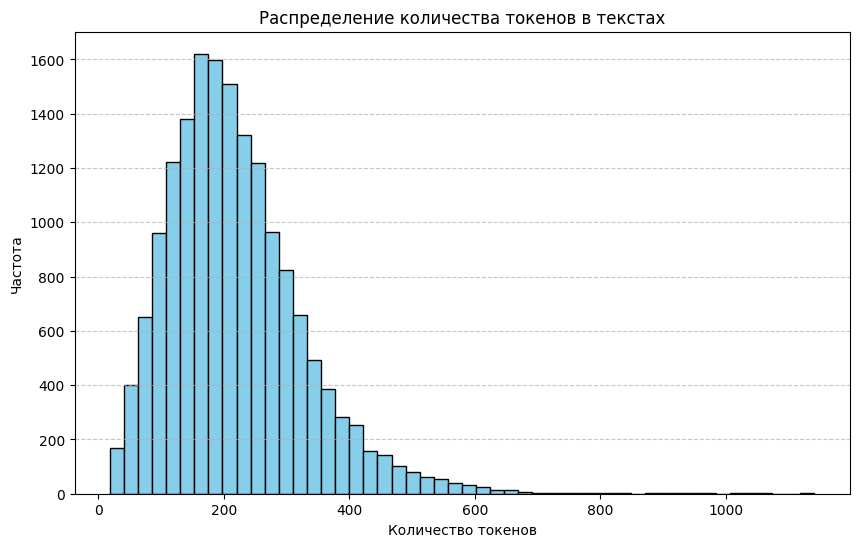

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
token_counts = df_train["clean_description"].apply(lambda x: len(tokenizer.tokenize(x)))

stats = {
    "mean": token_counts.mean(),
    "median": token_counts.median(),
    "min": token_counts.min(),
    "max": token_counts.max(),
    "std": token_counts.std()
}

print("Статистика по количеству токенов:")
for key, value in stats.items():
    print(f"{key.capitalize()}: {value:.2f}")

# Построение гистограммы для подсчета токенов в текстах
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=50, color="skyblue", edgecolor="black")
plt.title("Распределение количества токенов в текстах")
plt.xlabel("Количество токенов")
plt.ylabel("Частота")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
num_bins = 4  # Количество бинов для стратифицированное деления датасета
df_train["bucket_target"] = pd.qcut(df_train["log_salary_from"], q=num_bins, labels=False)

### Получение эмбеддингов для скиллов (делалось уже после первой модели)

In [ ]:
import torch
from transformers import T5EncoderModel, T5Tokenizer

MODEL_NAME = 'basil-77/rut5-base-absum-hh'
model_t5 = T5EncoderModel.from_pretrained(MODEL_NAME)
tokenizer_t5 = T5Tokenizer.from_pretrained(MODEL_NAME)

config.json:   0%|          | 0.00/872 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/977M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/329 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/828k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

In [ ]:
class SkillsDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.skills = df["skills"].fillna("").tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.skills)

    def __getitem__(self, idx):
        text = self.skills[idx]
        tokens = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        return {
            "input_ids": tokens["input_ids"].squeeze(0),
            "attention_mask": tokens["attention_mask"].squeeze(0)
        }

def compute_embeddings_with_dataloader(df, tokenizer, model, device, batch_size=64, max_length=512):
    dataset = SkillsDataset(df, tokenizer, max_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    embeddings = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Computing embeddings"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Получение эмбеддингов
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_embeddings = outputs.last_hidden_state.max(dim=1).values.cpu().numpy()
            embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

embeddings = compute_embeddings_with_dataloader(
    df_train,
    tokenizer_t5,
    model_t5,
    device,
    batch_size=64,
    max_length=128
)

Computing embeddings: 100%|██████████| 261/261 [01:08<00:00,  3.79it/s]


In [25]:
np.save("skills_embeddings.npy", embeddings)

In [9]:
embeddings_skills = np.load("skills_embeddings.npy")

df_train["embeddings_skills"] = list(embeddings_skills)

In [10]:
df_train["skills_str"] = df_train["skills"].fillna("").apply(lambda x: ", ".join(x.split(",")))

# Разделение данных на train/val
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=64, stratify=df_train["bucket_target"])
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [ ]:
# Обучение TfidfVectorizer на train
tfidf = TfidfVectorizer(min_df=1, token_pattern=r"[^,]+")
skills_tfidf_train = tfidf.fit_transform(train_df["skills_str"])

# Применение TfidfVectorizer к val
skills_tfidf_val = tfidf.transform(val_df["skills_str"])

# Преобразование в DataFrame
skills_tfidf_train_df = pd.DataFrame(skills_tfidf_train.toarray(), columns=tfidf.get_feature_names_out())
skills_tfidf_val_df = pd.DataFrame(skills_tfidf_val.toarray(), columns=tfidf.get_feature_names_out())

# Добавление TF-IDF признаков
train_df = pd.concat([train_df, skills_tfidf_train_df], axis=1)
val_df = pd.concat([val_df, skills_tfidf_val_df], axis=1)

In [ ]:
label_encoder_location = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
train_df["location_encoded"] = label_encoder_location.fit_transform(train_df[["location"]])

val_df["location_encoded"] = label_encoder_location.transform(val_df[["location"]])

label_encoder_company = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

train_df["company_encoded"] = label_encoder_company.fit_transform(train_df[["company"]])
val_df["company_encoded"] = label_encoder_company.transform(val_df[["company"]])

train_df = train_df.fillna(-1)
val_df = val_df.fillna(-1)

# Baseline end2end model (transformer + dnn)

In [ ]:
class SalaryDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512, columns_features=None):
        features = ["title", "clean_description", "embeddings_skills"]
        if "log_salary_from" in df.columns:
            features.append("log_salary_from")
            features.append("bucket_target")

        self.df = df[features + (columns_features if columns_features is not None else [])]
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.columns_features = columns_features

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        text = f"{row['title']} [SEP] {row['clean_description']}"
        
        tokens = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )

        input_ids = tokens["input_ids"].squeeze(0)
        attention_mask = tokens["attention_mask"].squeeze(0)

        additional_features = torch.tensor(row[self.columns_features].values.astype(float), dtype=torch.float)

        
        data = {
            "input_ids": input_ids,          
            "attention_mask": attention_mask,
            "features": additional_features,
            "embeddings_skills": torch.tensor(row["embeddings_skills"].astype(float), dtype=torch.float32)
        }
        
        # Целевая переменная
        if "log_salary_from" in self.df.columns:
            target = row["log_salary_from"]
            target_bucket = row["bucket_target"]

            data["target"] = torch.tensor(target, dtype=torch.float)
            data["bucket_target"] = torch.tensor(target_bucket, dtype=torch.long)

        
        return data

In [ ]:
class SalaryModel(pl.LightningModule):
    def __init__(self, num_features, vocab_size, num_bins, embedding_dim=128, hidden_dim=256, num_heads=8, num_layers=4, max_length=512, dropout=0.3, embeddings_skills_dim: int = 0):
        super(SalaryModel, self).__init__()
        self.save_hyperparameters()
        self.validation_step_outputs = defaultdict(list)

        # Эмбеддинги для токенов
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Позиционные эмбеддинги
        self.positional_encoding = self._generate_positional_encoding(max_length, embedding_dim)
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=False
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        # Attention Pooling
        self.attention_weights = nn.Linear(embedding_dim, 1)

        self.shared_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(embedding_dim + num_features + embeddings_skills_dim, 256),
            nn.GELU(),
            nn.Linear(256, 128),
            nn.GELU(),
        )

        self.regression_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.cls_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_bins)
        )

        self.final_norm = nn.LayerNorm(embedding_dim)

        self.regression_loss = nn.SmoothL1Loss()
        self.classification_loss = nn.CrossEntropyLoss()

    def _generate_positional_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return nn.Parameter(pe.unsqueeze(0), requires_grad=True)

    def forward(self, input_ids, attention_mask, additional_features, embeddings_skills):
        embedded = self.token_embedding(input_ids)
        seq_len = embedded.size(1)
        embedded = embedded + self.positional_encoding[:, :seq_len, :].to(embedded.device)
        embedded = self.dropout(embedded)

        transformer_output = self.transformer(embedded, src_key_padding_mask=~attention_mask.bool())
        transformer_output = transformer_output + embedded

        attention_scores = self.attention_weights(transformer_output).squeeze(-1)
        attention_scores = attention_scores.masked_fill(~attention_mask.bool(), float('-inf'))
        attention_weights = torch.softmax(attention_scores, dim=1)
        pooled_output = torch.sum(transformer_output * attention_weights.unsqueeze(-1), dim=1)

        combined_features = torch.cat([self.final_norm(pooled_output), additional_features, embeddings_skills], dim=1)

        shared_features = self.shared_fc(combined_features)

        regression_output = self.regression_head(shared_features)
        classification_output = self.cls_head(shared_features)

        return regression_output.squeeze(), classification_output.squeeze()

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        features = batch["features"]
        embeddings_skills = batch["embeddings_skills"]

        cls_target = batch["bucket_target"]
        regression_target = batch["target"]

        regression_output, classification_output = self(input_ids, attention_mask, features, embeddings_skills)
        
        regression_loss = self.regression_loss(regression_output, regression_target)
        classification_loss = self.classification_loss(classification_output, cls_target)

        total_loss = 0.7 * regression_loss + 0.3 * classification_loss

        self.log("train_regression_loss", regression_loss, prog_bar=True)
        self.log("train_classification_loss", classification_loss, prog_bar=True)
        self.log("train_total_loss", total_loss, prog_bar=True)

        return total_loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        features = batch["features"]
        embeddings_skills = batch["embeddings_skills"]
        regression_target = batch["target"]
        classification_target = batch["bucket_target"]

        regression_output, classification_output = self(input_ids, attention_mask, features, embeddings_skills)

        regression_loss = self.regression_loss(regression_output, regression_target)
        classification_loss = self.classification_loss(classification_output, classification_target)

        total_loss = regression_loss + classification_loss

        self.log("val_regression_loss", regression_loss, prog_bar=True)
        self.log("val_classification_loss", classification_loss, prog_bar=True)
        self.log("val_total_loss", total_loss, prog_bar=True)

        self.validation_step_outputs["regression_preds"].append(regression_output)
        self.validation_step_outputs["regression_target"].append(regression_target)
        self.validation_step_outputs["classification_preds"].append(classification_output)
        self.validation_step_outputs["classification_target"].append(classification_target)

        return total_loss

    def on_validation_epoch_end(self) -> None:
        all_preds = torch.cat(self.validation_step_outputs["regression_preds"]).cpu().numpy()
        all_targets = torch.cat(self.validation_step_outputs["regression_target"]).cpu().numpy()
        r2 = r2_score(all_targets, all_preds)
        self.log("val_r2", r2, prog_bar=True)

        all_classification_preds = torch.cat(self.validation_step_outputs["classification_preds"]).argmax(dim=1).cpu().numpy()
        all_classification_targets = torch.cat(self.validation_step_outputs["classification_target"]).cpu().numpy()
        classification_f1 = f1_score(all_classification_targets, all_classification_preds, average="macro")
        self.log("val_f1", classification_f1, prog_bar=True) # type: ignore

        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=3e-5, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=1e-3,
            total_steps=self.trainer.estimated_stepping_batches, # type: ignore
            pct_start=0.3,
            anneal_strategy="linear",
            final_div_factor=10
        )
        return [optimizer], [scheduler]
    
    def on_train_start(self):
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in self.parameters())

        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Total parameters: {total_params:,}")
        print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

In [29]:
assert df_train.shape[0] == train_df.shape[0] + val_df.shape[0]

In [30]:
num_features = ["company_encoded", "location_encoded", "experience_from"]

In [31]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

train_dataset = SalaryDataset(train_df, tokenizer, max_length=1024, columns_features=num_features)
val_dataset = SalaryDataset(val_df, tokenizer, max_length=1024, columns_features=num_features)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Обучение модели

In [21]:
task = Task.init(
    project_name="Competitions/teta_nn_1_2025_predict_salary",
    task_name="Training baseline end-to-end model v1.3",
    task_type=TaskTypes.training,
    tags=["training", "transformer", "end2end"],
    auto_connect_frameworks={"pytorch": True},
    output_uri=True,
)

ClearML Task: created new task id=9a1995884cf84e9abe8ed2cb781ef47d
2025-07-24 09:51:28,652 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/8870d7f669ca45988ef171246b781921/experiments/9a1995884cf84e9abe8ed2cb781ef47d/output/log


In [32]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_r2",
    dirpath="checkpoints/",
    filename="salary_prediction_v1.0-{epoch:02d}-{val_loss:.2f}-{val_r2:.4f}",
    save_top_k=2,
    mode="min",
    every_n_epochs=2
)

early_stopping = EarlyStopping(
    monitor="val_r2",
    min_delta=0.001,
    mode="max",
    patience=3
)

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[checkpoint_callback],
    log_every_n_steps=50
)

model = SalaryModel(
    num_features=len(num_features),
    vocab_size=tokenizer.vocab_size,
    num_bins=num_bins,
    embedding_dim=512,
    hidden_dim=512,
    num_heads=8,
    num_layers=8,
    max_length=1024,
    dropout=0.1,
    embeddings_skills_dim=embeddings_skills.shape[1]
)

torch.compile(model)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.



Training: |          | 0/? [00:00<?, ?it/s]

Trainable parameters: 69,043,270
Total parameters: 69,043,270
Percentage trainable: 100.00%


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-24 10:33:19,610 - clearml.storage - INFO - Uploading: 790.27MB from /tmp/.clearml.upload_model_st82haob.tmp


█████████████████████████████ 100% | 790.27/790.27 MB [01:03<00:00, 12.36MB/s]: 

2025-07-24 10:34:23,578 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Competitions/teta_nn_1_2025_predict_salary/Training%20baseline%20end-to-end%20model%20v1.3.9a1995884cf84e9abe8ed2cb781ef47d/models/salary_prediction_v1.0-epoch%3D01-val_loss%3D0.00-val_r2%3D-8.4071.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-24 10:59:16,097 - clearml.storage - INFO - Uploading: 790.27MB from /tmp/.clearml.upload_model_8l2z5pox.tmp


█████████████████████████████ 100% | 790.27/790.27 MB [01:04<00:00, 12.19MB/s]: 

2025-07-24 11:00:20,910 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Competitions/teta_nn_1_2025_predict_salary/Training%20baseline%20end-to-end%20model%20v1.3.9a1995884cf84e9abe8ed2cb781ef47d/models/salary_prediction_v1.0-epoch%3D03-val_loss%3D0.00-val_r2%3D-9.2063.ckpt


NameError: name 'exit' is not defined

## Предсказание на тестовых данных

In [ ]:
try:
    best_train_model = InputModel("f66fa53c15934164a2ae7cbd881f6067")
    path_model = best_train_model.get_local_copy()
except NameError:
    print("Можно взять модель только локально")
    path_model = "temp"

█████████████████████████████ 100% | 649.89/649.89 MB [00:10<00:00, 62.04MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████ 100% | 649.89/649.89 MB [00:10<00:00, 61.72MB/s]: 


In [46]:
model = SalaryModel.load_from_checkpoint(path_model)

model.eval()
model.freeze()

In [54]:
df_test = pd.read_csv("/kaggle/working/test.csv")
df_test = df_test.fillna("")

df_test["clean_description"] = df_test["description"].apply(clean_text)

df_test["skills_str"] = df_test["skills"].apply(lambda x: ",".join(x.split(",")))
df_test["location"] = df_test["location"].apply(lambda x: re.sub(r"\(+.*?\)+", "", x).strip())

skills_tfidf_val = tfidf.transform(df_test["skills_str"])
skills_tfidf_df = pd.DataFrame(skills_tfidf_val.toarray(), columns=tfidf.get_feature_names_out())
df_test = pd.concat([df_test, skills_tfidf_df], axis=1).fillna(0)

df_test["location_encoded"] = label_encoder.transform(df_test[["location"]])

In [ ]:
# Добавлялось после основной (первой модели)
embeddings_test = compute_embeddings_with_dataloader(
    df_test,
    tokenizer_t5,
    model_t5,
    device,
    batch_size=64,
    max_length=128
)
np.save("skills_embeddings_test.npy", embeddings_test)

Computing embeddings: 100%|██████████| 87/87 [00:22<00:00,  3.85it/s]


In [50]:
test_dataset = SalaryDataset(df_test, tokenizer, max_length=1024, columns_features=num_features)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [55]:
def evaluate_test(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features = batch["features"].to(device)

            outputs = model(input_ids, attention_mask, features)

            predictions.extend(outputs.cpu().numpy())

    return predictions

In [56]:
test_preds = evaluate_test(model, test_loader)

test_predictions = pd.DataFrame({
    "prediction": test_preds
}).reset_index()

test_predictions.to_csv("submission.csv", index=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:502: UserWarning:

The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)

100%|██████████| 87/87 [00:30<00:00,  2.86it/s]


In [65]:
!wc -l ./submission.csv

5557 ./submission.csv


In [66]:
!kaggle competitions submit -c teta-nn-1-2025 -f /kaggle/working/submission.csv -m "Baseline + new features"

100%|███████████████████████████████████████| 77.9k/77.9k [00:00<00:00, 121kB/s]
Successfully submitted to teta_nn_1_2025

In [67]:
task.close()

# Feature extraction с помощью tinybert и обучение catboost

In [ ]:
import numpy as np
from catboost import CatBoostRegressor, Pool
from transformers import BertModel, BertTokenizerFast

In [17]:
tokenizer = BertTokenizerFast.from_pretrained("cointegrated/rubert-tiny2")
bert_model = BertModel.from_pretrained("cointegrated/rubert-tiny2").to(device)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

In [18]:
class BertEmbeddingDataset(Dataset):
    def __init__(self, df, columns, tokenizer, max_length=512, columns_features=None):
        self.df = df[columns].copy()
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.columns_features = columns_features

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = " | ".join([row[col] for col in self.df.columns])
        inputs = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        
        return {k: v.squeeze(0) for k, v in inputs.items()}

In [ ]:
def compute_bert_embeddings_with_dataloader(df, tokenizer, columns: list[str], model, device, batch_size=128, max_length=128, layers_to_use=[-1, -2, -3, -4]):
    dataset = BertEmbeddingDataset(df, columns, tokenizer, max_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Computing BERT embeddings"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
            hidden_states = outputs.hidden_states

            selected_layers = [nn.functional.normalize(hidden_states[i][:, 0, :]) for i in layers_to_use]

            sum_last_four_cls = torch.sum(torch.stack(selected_layers), dim=0)

            embeddings.append(sum_last_four_cls.cpu().numpy())

    return np.vstack(embeddings)


train_bert_emb_title = compute_bert_embeddings_with_dataloader(train_df, tokenizer, ["title"], bert_model, device, batch_size=256, max_length=32, layers_to_use=[-1])
val_bert_emb_title = compute_bert_embeddings_with_dataloader(val_df, tokenizer, ["title"], bert_model, device, batch_size=256, max_length=32, layers_to_use=[-1])

train_bert_emb_descripion = compute_bert_embeddings_with_dataloader(train_df, tokenizer, ["clean_description"], bert_model, device, batch_size=256, max_length=650, layers_to_use=[-1, -2, -3, -4])
val_bert_emb_description = compute_bert_embeddings_with_dataloader(val_df, tokenizer, ["clean_description"], bert_model, device, batch_size=256, max_length=650, layers_to_use=[-1, -2, -3, -4])

Computing BERT embeddings: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


In [ ]:
X_train = np.hstack([
    train_df[["company_encoded", "location_encoded", "experience_from"]].values,
    np.vstack(train_df["embeddings_skills"].values),
    train_bert_emb_title,
    train_bert_emb_descripion
])


X_val = np.hstack([
    val_df[["company_encoded", "location_encoded", "experience_from"]].values,
    np.vstack(val_df["embeddings_skills"].values),
    val_bert_emb_title,
    val_bert_emb_description
])

y_train = train_df["log_salary_from"].values
y_val = val_df["log_salary_from"].values

In [ ]:
index_cat_features = list(range(len(["company_encoded", "location_encoded"])))

train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_val, y_val)

In [ ]:
task = Task.init(
    project_name="Competitions/teta_nn_1_2025_predict_salary",
    task_name="Training catboost with bert extract features sum layers v1.0",
    task_type=TaskTypes.training,
    tags=["training", "transformer", "catboost", "bert"],
    auto_connect_frameworks={"catboost": True},
    output_uri=True,
)

ClearML Task: created new task id=4baf0f5612a94dc6ad5cb7f2a83c8150
2025-07-22 23:48:41,338 - clearml.Repository Detection - WARNING - Jupyter Notebook auto-logging failed, could not access: /kaggle/working/baseline-jvsc-9571efc2-7c10-4e64-986a-1b4256bb7281a475974b-72f4-442b-8b58-9ef57b8f425f.ipynb
2025-07-22 23:48:41,361 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/8870d7f669ca45988ef171246b781921/experiments/4baf0f5612a94dc6ad5cb7f2a83c8150/output/log


## Обучение модели

In [ ]:
catboost_model = CatBoostRegressor(
    iterations=4000,
    learning_rate=0.07,
    depth=10,
    loss_function="RMSE",
    eval_metric="R2",
    early_stopping_rounds=50,
    verbose=20,
    random_seed=RANDOM_SEED,
    task_type="CPU",
    use_best_model=True

)
catboost_model.fit(train_pool, eval_set=valid_pool)

0:	learn: 0.1375572	test: 0.1270861	best: 0.1270861 (0)	total: 3.14s	remaining: 3h 29m 18s
20:	learn: 0.7034930	test: 0.6033905	best: 0.6033905 (20)	total: 1m 5s	remaining: 3h 28m 15s
40:	learn: 0.7746932	test: 0.6226797	best: 0.6226797 (40)	total: 2m 8s	remaining: 3h 27m 17s
60:	learn: 0.8166625	test: 0.6275902	best: 0.6277364 (59)	total: 3m 11s	remaining: 3h 26m 36s


KeyboardInterrupt: 

## Предсказание на тестовых данных

In [18]:
df_test = pd.read_csv("/kaggle/working/test.csv")

In [152]:
df_test["clean_description"] = df_test["description"].apply(clean_text)
df_test["location"] = df_test["location"].apply(lambda x: re.sub(r"\(+.*?\)+", "", x).strip())
df_test["title"] = df_test["title"].apply(lambda x: re.sub(r"\(+.*?\)+", "", x).strip())

df_test["embeddings_skills"] = list(np.load("skills_embeddings_test.npy"))

In [153]:
df_test["location_encoded"] = label_encoder_location.transform(df_test[["location"]])

df_test["company_encoded"] = label_encoder_company.transform(df_test[["company"]])

df_test = df_test.fillna(-1)

In [154]:
test_bert_emb_title = compute_bert_embeddings_with_dataloader(df_test, tokenizer, ["title"], bert_model, device, batch_size=256, max_length=32, layers_to_use=[-1])

test_bert_emb_description = compute_bert_embeddings_with_dataloader(df_test, tokenizer, ["description"], bert_model, device, batch_size=256, max_length=650, layers_to_use=[-1, -2, -3, -4])

Computing BERT embeddings: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


In [155]:
X_test = np.hstack([
    df_test[["company_encoded", "location_encoded", "experience_from"]].values,
    np.vstack(df_test["embeddings_skills"].values),
    test_bert_emb_title,
    test_bert_emb_description
])

test_pool = Pool(X_test)

In [156]:
test_preds = catboost_model.predict(test_pool)

test_predictions = pd.DataFrame({
    "prediction": test_preds
}).reset_index()

test_predictions.to_csv("submission.csv", index=False)

In [157]:
!wc -l ./submission.csv

5557 ./submission.csv


In [158]:
!kaggle competitions submit -c teta-nn-1-2025 -f /kaggle/working/submission.csv -m "Bert extraction text sum layers + t5 extract skills + catboost regression v1.1"

100%|█████████████████████████████████████████| 126k/126k [00:00<00:00, 203kB/s]
Successfully submitted to teta_nn_1_2025

In [63]:
task.close()

# Fine-tune deberta

In [12]:
from transformers import AutoTokenizer, DebertaModel

In [13]:
class BertVacancyDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512, table_features=None):
        features = ["title", "clean_description", "embeddings_skills"]
        if "log_salary_from" in df.columns:
            features.append("log_salary_from")

        self.df = df[features + (table_features if table_features is not None else [])]
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.table_features = table_features

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Текст вакансии
        text = f"{row['title']} {row['clean_description']}"
        
        # Токенизация текста с обрезкой до max_length
        tokens = self.tokenizer(
            "clustering: " + text,
            truncation=True,  # Обрезаем текст до max_length
            max_length=self.max_length,
            padding="max_length",  # Дополняем до max_length
            return_tensors="pt"
        )
        inputs = {k: v.squeeze(0) for k, v in tokens.items()}

        additional_features = torch.tensor(row[self.table_features].values.astype(float), dtype=torch.float32)
        inputs["embeddings_skills"] = torch.tensor(row["embeddings_skills"].astype(float), dtype=torch.float32)
        inputs["features"] = additional_features
        
        # Целевая переменная
        if "log_salary_from" in self.df.columns:
            target = row["log_salary_from"]

            inputs["target"] = torch.tensor(target, dtype=torch.float)
        
        return inputs

In [14]:
num_features = ["company_encoded", "location_encoded", "experience_from"]
tokenizer = AutoTokenizer.from_pretrained("deepvk/deberta-v1-distill")

train_dataset = BertVacancyDataset(train_df, tokenizer, max_length=512, table_features=num_features)
val_dataset = BertVacancyDataset(val_df, tokenizer, max_length=512, table_features=num_features)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
class BertRegressor(pl.LightningModule):
    def __init__(self, pretrained_model, num_features, embeddings_skills, dropout=0.1):
        super().__init__()
        self.save_hyperparameters()
        self.validation_step_outputs = defaultdict(list)

        self.bert = pretrained_model
        self.hidden_size = self.bert.config.hidden_size

        for param in self.bert.embeddings.parameters():
            param.requires_grad = False

        # for i in range(2):
            # for param in self.bert.encoder.layer[i].parameters():
                # param.requires_grad = False

        # self.attention_weights = nn.Linear(self.hidden_size, 1)

        # Финальный линейный слой
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(self.hidden_size + num_features + embeddings_skills, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.criterion = nn.HuberLoss(delta=0.5)

    def forward(self, input_ids, attention_mask, additional_features, embeddings_skills):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # attention_scores = torch.softmax(self.attention_weights(outputs.last_hidden_state), dim=1)
        # pooled_output = torch.sum(outputs.last_hidden_state * attention_scores, dim=1)

        embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings = torch.nn.functional.normalize(embeddings)

        combined_features = torch.cat([embeddings, additional_features, embeddings_skills], dim=1)

        output = self.fc(combined_features)

        return output.squeeze()

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        # token_type_ids = batch["token_type_ids"]
        additional_features = batch["features"]
        embeddings_skills = batch["embeddings_skills"]
        targets = batch["target"]

        predictions = self(input_ids, attention_mask, additional_features, embeddings_skills)
        loss = self.criterion(predictions, targets)
        self.log("train_loss", loss, prog_bar=True)

        current_lr = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log("learning_rate", current_lr, prog_bar=True, on_step=True)

        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        # token_type_ids = batch["token_type_ids"]
        additional_features = batch["features"]
        embeddings_skills = batch["embeddings_skills"]
        targets = batch["target"]

        outputs = self(input_ids, attention_mask, additional_features, embeddings_skills)
        loss = self.criterion(outputs, targets)
        self.log("val_loss", loss, prog_bar=True)

        self.validation_step_outputs["preds"].append(outputs)
        self.validation_step_outputs["target"].append(targets)

        return loss

    def on_validation_epoch_end(self) -> None:
        all_preds = torch.cat(self.validation_step_outputs["preds"]).cpu().numpy()
        all_targets = torch.cat(self.validation_step_outputs["target"]).cpu().numpy()

        r2 = r2_score(all_targets, all_preds)

        self.log("val_r2", r2, prog_bar=True)

        self.validation_step_outputs.clear()

    def configure_optimizers(self): # type: ignore
        optimizer = optim.AdamW(self.parameters(), lr=5e-4, weight_decay=1e-2, eps=1e-6)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=10,  # Количество шагов до первого сброса
            T_mult=2,  # Увеличение периода сброса
            eta_min=1e-8,  # Минимальный LR
            last_epoch=-1
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "name": "lr/CosineAnnealingWarmRestarts",
            },
        }
    
    def on_train_start(self):
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in self.parameters())

        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Total parameters: {total_params:,}")
        print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

In [16]:
task = Task.init(
    project_name="Competitions/teta_nn_1_2025_predict_salary",
    task_name="Extract skills t5 and deberta freezing embeddings v1.1",
    task_type=TaskTypes.training,
    tags=["training", "transformer", "deberta-distil", "basil-77/rut5-base-absum-hh"],
    auto_connect_frameworks={"pytorch": True},
    output_uri=True,
)

ClearML Task: created new task id=18cda8ab285947aebdafd0ac7840f757
2025-07-24 19:32:16,194 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/8870d7f669ca45988ef171246b781921/experiments/18cda8ab285947aebdafd0ac7840f757/output/log


ClearML results page: https://app.clear.ml/projects/8870d7f669ca45988ef171246b781921/experiments/18cda8ab285947aebdafd0ac7840f757/output/log
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [23]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_r2",
    dirpath="checkpoints/",
    filename="salary_prediction_v1.0-{epoch:02d}-{val_loss:.2f}-{val_r2:.4f}",
    save_top_k=2,
    mode="max",
    every_n_epochs=2
)

early_stopping = EarlyStopping(
    monitor="val_r2",
    min_delta=0.001,
    mode="max",
    patience=2
)

trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[checkpoint_callback],
    log_every_n_steps=50
)

model_bert_tiny = DebertaModel.from_pretrained("deepvk/deberta-v1-distill").to(device)

model = BertRegressor( 
    model_bert_tiny,
    num_features=len(num_features),
    embeddings_skills=embeddings_skills.shape[1]
)

torch.compile(model)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/saving.py:363: UserWarning:

Skipping 'pretrained_model' parameter because it is not possible to safely dump to YAML.



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.



Training: |          | 0/? [00:00<?, ?it/s]

Trainable parameters: 42,949,889
Total parameters: 81,948,161
Percentage trainable: 52.41%


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-24 19:49:05,793 - clearml.storage - INFO - Uploading: 640.44MB from /tmp/.clearml.upload_model_cy903yi9.tmp


█████████████████████████████ 100% | 640.44/640.44 MB [00:11<00:00, 55.56MB/s]: 

2025-07-24 19:49:17,335 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Competitions/teta_nn_1_2025_predict_salary/Extract%20skills%20t5%20and%20deberta%20freezing%20embeddings%20v1.1.18cda8ab285947aebdafd0ac7840f757/models/salary_prediction_v1.0-epoch%3D01-val_loss%3D0.13-val_r2%3D0.1549.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-24 20:03:24,411 - clearml.storage - INFO - Uploading: 640.44MB from /tmp/.clearml.upload_model_voky6vqf.tmp


█████████████████████████████ 100% | 640.44/640.44 MB [00:12<00:00, 51.49MB/s]: 

2025-07-24 20:03:36,858 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Competitions/teta_nn_1_2025_predict_salary/Extract%20skills%20t5%20and%20deberta%20freezing%20embeddings%20v1.1.18cda8ab285947aebdafd0ac7840f757/models/salary_prediction_v1.0-epoch%3D03-val_loss%3D0.27-val_r2%3D-1.2892.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-24 20:17:39,277 - clearml.storage - INFO - Uploading: 640.44MB from /tmp/.clearml.upload_model__h4v08iv.tmp


█████████████████████████████ 100% | 640.44/640.44 MB [00:11<00:00, 53.92MB/s]: 

2025-07-24 20:17:51,162 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Competitions/teta_nn_1_2025_predict_salary/Extract%20skills%20t5%20and%20deberta%20freezing%20embeddings%20v1.1.18cda8ab285947aebdafd0ac7840f757/models/salary_prediction_v1.0-epoch%3D05-val_loss%3D0.11-val_r2%3D0.2866.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

NameError: name 'exit' is not defined

In [51]:
task.close()